# Diffusion Models for Inverse Problems

M2 MVA course, Deep Learning for Image Restoration & Synthesis

Authors: Charles Laroche & Andrés Almansa

## I) Setup <a class="anchor" id="chapter2"></a>

In [4]:
# Set home directory containing this notebook + data

HOMEDIR = "."

### Mount Google Drive

In [5]:
# from google.colab import drive
# drive.mount('/content/drive')

Go to the folder in Google drive where you downloaded the provided code. And check its contents.

In [6]:
%cd $HOMEDIR
!ls -l

/Data/code/MVA24-delire/TP_3
total 3084
drwxrwxr-x 1 bneveu bneveu     184 janv. 27 21:04 data
drwxrwxr-x 1 bneveu bneveu      72 sept. 22 16:02 images_notebook
drwxrwxr-x 1 bneveu bneveu      24 janv. 30 16:07 __MACOSX
-rwxr-xr-x 1 bneveu bneveu     619 janv. 28 03:16 README.md
-rw-rw-r-- 1 bneveu bneveu  281605 févr. 27 02:25 tp_3.html
-rw-rw-r-- 1 bneveu bneveu    8606 févr. 27 02:25 tp_3.ipynb
drwxrwxr-x 1 bneveu bneveu     102 janv. 30 16:08 TP-DM
-rwxrwxr-x 1 bneveu bneveu  772376 févr. 27 10:48 TP-DM.ipynb
-rw-r--r-- 1 bneveu bneveu   26158 janv. 30 12:16 TP-DM.md
-rw-r--r-- 1 bneveu bneveu 2055656 janv. 30 12:17 TP-DM.pdf
drwxrwxr-x 1 bneveu bneveu     132 janv. 27 19:25 utils


### Select GPU / CPU

By the end of this section `device` should point to a cuda or mps GPU if one is available, otherwise it should point to a CPU.

For google colab: If a cuda GPU is not available, change the runtime type in the Runtime menu.

In [7]:
!nvidia-smi

Tue Feb 27 10:50:51 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.147.05   Driver Version: 525.147.05   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA T500         Off  | 00000000:01:00.0 Off |                  N/A |
| N/A   53C    P0    N/A /  N/A |      5MiB /  4096MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

The following code checks if Apple Silicon or nvidia GPU is available.
In that case it sets `device` to "mps" or "cuda" respectively.
Otherwise fallback to `device="cpu"`.
If you have access to a TPU in google colab or another non-cuda GPU you may need to change the code below.

In [8]:
import torch
torch.cuda.is_available()

True

In [9]:
# Select best GPU, fallback to CPU if no GPU is available
import os, torch

# If Apple Silicon processor is available set device to "mps"
if torch.backends.mps.is_available():
    device = torch.device("mps")
# If nvidia GPU is available set device to "cuda"
elif torch.cuda.is_available():
    device = torch.device("cuda")
# otherwise fallback to "cpu"
else:
    device = torch.device("cpu")
    print ("GPU not found using CPU.")

# device = torch.device("cpu")

device

device(type='cuda')

### Install required packages

In [10]:
# !pip install diffusers accelerate

### Import required libraries

In [11]:
import matplotlib.pyplot as plt
import torch
import tqdm
import utils.utils_image as util
import utils.utils_agem as agem

##  II) DDPM: Denoising Diffusion Probabilistic Models<a class="anchor" id="section_2_1"></a>

### Introduction

![DDPM](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/DDPM.png)

Denoising diffusion probabilistic models (DDPM) can learn to sample from a distribution of natural images $p(x_0)$. 

To do so, they first define a forward process that progressively adds Gaussian noise to $x_0$ until $x_T \sim \mathcal{N}(0,I)$ :

$$
\begin{align*}
& q(x_{1:T}|x_0) = \prod_{t=1}^T{q(x_{t}|x_{t-1})} \\
& q(x_{t}|x_{t-1}) = \mathcal{N}(x_t;\sqrt{1-\beta_t}x_{t-1}, \beta_t Id) \\
& x_t = \sqrt{1-\beta_t}x_{t-1}  + \sqrt{\beta_t} e_t \quad \text{where} \quad e_t \sim \mathcal{N}(0,Id) \\
& x_t = \sqrt{\bar{\alpha_t}}x_{0}  + \sqrt{1-\bar{\alpha_t}} \epsilon_t \quad \text{where} \quad \epsilon_t \sim \mathcal{N}(0,Id), \ \ \bar{\alpha_t} = \prod_{s=1}^t{(1-\beta_s)}
\end{align*}
$$

In order to sample from $q(x_0)$ we need to estimate the reverse process $q(x_{t-1}|x_{t})$.

According to (Feller 1949; [Sohl-Dickstein et al 2015]((https://arxiv.org/pdf/1503.03585.pdf))), if $\beta_t$ is infinitesimally small then $q(x_{t-1}|x_{t})$ is also Gaussian, so we can approximate it by 

$$ p_\theta(x_{t-1}|x_{t}) = \mathcal{N}(x_t; \mu_\theta(x_t,t), \sigma_t^2 I)$$

Using variational inference tools ([Ho et al 2020](https://proceedings.neurips.cc/paper/2020/hash/4c5bcfec8584af0d967f1ab10179ca4b-Abstract.html)) conclude that

- $\mu_\theta(x_t,t) = \frac{1}{\sqrt{\alpha_t}} \left(x_{t} - \frac{1 - \alpha_t}{\sqrt{1 - \bar{\alpha_t}}} \hat\epsilon_\theta(x_t, t)\right)$

- $\sigma_t^2 = \frac{1 - \bar{\alpha}_{t-1}}{1 - \bar{\alpha}_{t}}\beta_t$

where $\hat\epsilon_\theta(x_t,t)$ is a neural network (denoiser) that is trained to predict the noise $\epsilon_t$ in $x_t = \sqrt{\bar{\alpha_t}}x_{0}  + \sqrt{1-\bar{\alpha_t}}\epsilon_t$.

The DDPM sampling algorithm is summarized as follows

***
$\mathbf{\text{DDPM Algorithm}}$<br>
***
1.&emsp;Initialize $x_T \sim \mathcal{N}(0,1)$<br>
2.&emsp;For t = T to 0:<br>
&emsp; &emsp; $\hat\epsilon = \epsilon_\theta(x_t, t)$<br>
&emsp; &emsp; $z_t = \mathcal{N}(0,I)$ <br>
&emsp; &emsp; $x_{t-1} = \frac{1}{\sqrt{\alpha_t}} \left(x_{t} - \frac{\beta_t}{\sqrt{1 - \bar{\alpha_t}}}  \hat\epsilon \right) + \sigma_t z_t$
<br>

3. Output $x_0$
***

### Questions

In the sequel we shall need to establish a link between

* the noise estimator $\hat\epsilon_\theta$ and
* the score function $\nabla \log p(x_t)$.

This is the goal of the following questions:

> **Question 1:** Use the definition of the forward process $x_t \sim \mathcal{N}( \sqrt{\bar{\alpha_t}}x_{0},\,(1-\bar{\alpha_t}) I)$ and Tweedie's identity to show that 
> $ \widehat{x_0}(x_t) = E[x_0|x_t] = \frac{1}{\sqrt{\bar\alpha_t}} \left( x_t + (1-\bar\alpha_t) \nabla \log p(x_t) \right) $.

> **Question 2:** Use the defition of the forward process $x_t = \sqrt{\bar\alpha_t} x_0 + \sqrt{1-\bar\alpha_t}\, \epsilon$ to find an expression of $x_0$ in terms of $\epsilon$

> **Question 3:** Conclude from the two previous results that
>
> ​	$\nabla \log p(x_t) = - \frac{1}{\sqrt{1-\bar\alpha_t}} \hat\epsilon_\theta(x_t)$​

> **Question 4:** Use the previous result to show that the unconditional DDPM update rule can be written in terms of the score as
> $$ x_{t-1}' = \frac{1}{\sqrt{\alpha_t}} \left(x_{t} + (1 - \alpha_t) \nabla \log p(x_t) \right) + \sigma_t z_t$$ 


### Using the pipeline

Now we are ready to load a pretrained DDPM model and use it to sample from the distribution of face images on which it was trained.

To do so we use the diffusers library from HuggingFace.

diffusion_pytorch_model.safetensors not found


Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

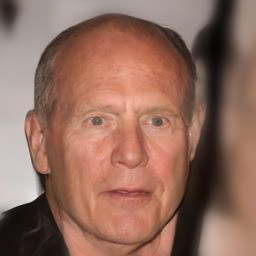

In [12]:
from diffusers import DDPMPipeline

# Load pretrained model from https://huggingface.co/models?sort=downloads&search=ddpm
model_name="google/ddpm-ema-celebahq-256" # 256x256 8 iteratons/second

ddpm = DDPMPipeline.from_pretrained(model_name).to(device)
image = ddpm(num_inference_steps=100).images[0]
image

### What's behind

The pipeline is composed of two main elements:
* `unet` is the pretrained score model that is used to predict $x_0$ from $x_t$ and $t$. 
* `scheduler` contains the values $\beta_t$, $\alpha_t$ and $\bar\alpha_t$, as well as the function to predict $x_{t-1}$ from $x_t$ and $t$.

In [13]:
# Either load pipeline from pretrained models
ddpm = DDPMPipeline.from_pretrained(model_name).to(device)
# and then extract scheduler and model
scheduler = ddpm.scheduler
model = ddpm.unet

# Or load scheduler and model directly
# from diffusers import DDPMScheduler, UNet2DModel
# scheduler = DDPMScheduler.from_pretrained(model_name)
# model = UNet2DModel.from_pretrained(model_name).to(device)

# You can also try a different scheduler
# from diffusers import DDIMScheduler, UNet2DModel
# scheduler = DDIMScheduler.from_pretrained(model_name)
# model = UNet2DModel.from_pretrained(model_name).to(device)

scheduler.set_timesteps(100)

diffusion_pytorch_model.safetensors not found


Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

In [15]:
# model

Next we shall use the scheduler and the model to write a lower level version of the DDPM sampling algorithm.

Before that,
* let's have a look at the scheduler (this requires somme utility functions below)
* and let's have a look at the UNet model.

#### Utility functions

In [40]:
def scheduler_alpha_t(scheduler, t):
    # Get \bar\alpha_t and \alpha_t from scheduler
    #   t should be an integer between 0 and T
    #   T = scheduler.num_train_timesteps # 1000
    prev_t = scheduler.previous_timestep(t)
    alpha_prod_t = scheduler.alphas_cumprod[t]
    alpha_prod_t_prev = scheduler.alphas_cumprod[prev_t] if prev_t >= 0 else scheduler.one
    #beta_prod_t = 1 - alpha_prod_t
    #beta_prod_t_prev = 1 - alpha_prod_t_prev
    current_alpha_t = alpha_prod_t / alpha_prod_t_prev
    #current_beta_t = 1 - current_alpha_t
    return alpha_prod_t, current_alpha_t


def print_scheduler(scheduler, T, stride):
    #T = scheduler.num_train_timesteps # 1000
    print("T", "t", "eta_t", "alpha_prod_t", "beta_prod_t", "current_beta_t")
    for t in range(0,T,stride):
        alpha_prod_t, current_alpha_t = scheduler_alpha_t(scheduler, t)
        beta_prod_t = 1 - alpha_prod_t
        current_beta_t = 1 - current_alpha_t
        eta_t = current_beta_t / torch.sqrt(current_alpha_t)
        print(T, t, f"{eta_t.item():.4f} , {alpha_prod_t.item():.4f}, {beta_prod_t.item():.4f}, {current_beta_t.item():.4f}")
        
def scheduler_alphas(scheduler):
    T = scheduler.num_inference_steps # 1000
    stride=1
    n = T #math.ceil((T+1)/stride)
    alpha = torch.zeros(n)
    alpha_bar = torch.zeros(n)
    time = torch.zeros(n)
    for t in range(0,T,stride):
        alpha_prod_t, current_alpha_t = scheduler_alpha_t(scheduler, t)
        #beta_prod_t = 1 - alpha_prod_t
        #current_beta_t = 1 - current_alpha_t
        #bt = current_beta_t / torch.sqrt(current_alpha_t)
        alpha[t] = current_alpha_t
        alpha_bar[t] = alpha_prod_t
        time[t] = t
    return alpha, alpha_bar, time

#### Explore the scheduler


The variances $\beta_t$ of the VP (Ornstein Uhlenbeck) forward diffusion process are chosen such that:

* $\bar\alpha_0$ = 1
* $\bar\alpha_T = 0$

Let's plot the values of $\bar\alpha_t$ for $t \in [0, T]$.

1000


/home/bneveu/.local/lib/python3.10/site-packages/diffusers/configuration_utils.py:139: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


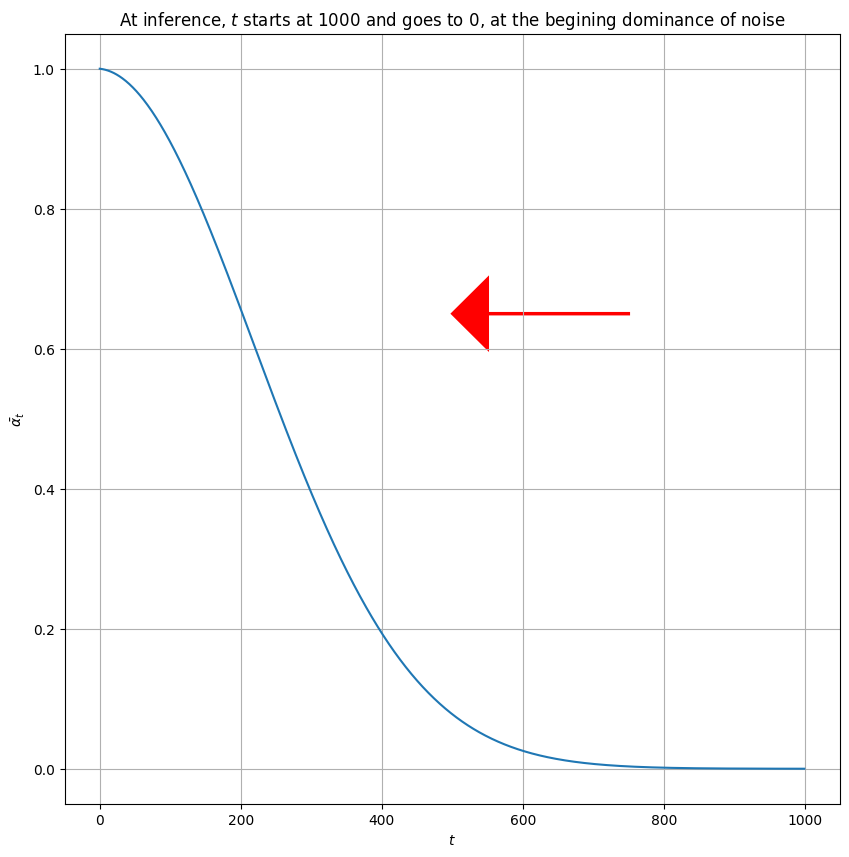

T t eta_t alpha_prod_t beta_prod_t current_beta_t
1000 0 0.0001 , 0.9999, 0.0001, 0.0001
1000 100 0.0021 , 0.8951, 0.1049, 0.0021
1000 200 0.0041 , 0.6563, 0.3437, 0.0041
1000 300 0.0061 , 0.3940, 0.6060, 0.0061
1000 400 0.0081 , 0.1936, 0.8064, 0.0081
1000 500 0.0101 , 0.0778, 0.9222, 0.0101
1000 600 0.0121 , 0.0256, 0.9744, 0.0121
1000 700 0.0141 , 0.0069, 0.9931, 0.0140
1000 800 0.0162 , 0.0015, 0.9985, 0.0160
1000 900 0.0182 , 0.0003, 0.9997, 0.0180


In [41]:
# T = number of timesteps during training
T = scheduler.num_train_timesteps # 1000

# TI = number of timesteps during inference
TI = T
scheduler.set_timesteps(TI)
print(scheduler.num_inference_steps)

# Get variance schedule
alpha, alpha_bar, time = scheduler_alphas(scheduler)

# Plot variance schedule
plt.figure(figsize=(10,10))
plt.plot(time, alpha_bar, label="alpha_bar")
plt.xlabel("$t$")
plt.ylabel("$\\bar{\\alpha_t}$")
plt.grid()
plt.arrow(750, 0.65, -200, 0,  lw=2., head_width=0.1, head_length=50, fc='r', ec='r')  # Add arrow

plt.title("At inference, $t$ starts at 1000 and goes to 0, at the begining dominance of noise")
plt.show()
# Print variance schedule
print_scheduler(scheduler, TI, int(TI/10))


#### DDPM Sampling in detail

Each iteration of the DDPM algorithm is composed of two steps:
1. Use the `model` to predict the noise from $x_t$
    $$\hat\epsilon_t = \epsilon_\theta(x_t, t)$$
2. Use the `scheduler` to sample $x_{t-1} \sim p_\theta(x_{t-1}|x_t)$:
    $$x_{t-1} = \frac{1}{\sqrt{\alpha_t}} \left(x_{t} - \frac{\beta_t}{\sqrt{1 - \bar{\alpha_t}}}  \hat\epsilon \right) + \mathcal{N}(0,\sigma_t^2 I)$$

In [13]:
def ddpm_sampling(model, scheduler, n_samples=1):
    # Get hyper_params
    sample_size = model.config.sample_size
    
    # Init random noise
    x_T = torch.randn((n_samples, 3, sample_size, sample_size)).to(device)
    x_t = x_T
    
    for t in tqdm.tqdm(scheduler.timesteps):
        with torch.no_grad():
            # Get noisy residual prediction 
            epsilon_t = model(x_t, t).sample
            
            # Sample x_{t-1}|x_t 
            x_t = scheduler.step(epsilon_t, t, x_t).prev_sample

    # Normalize output
    x_0 = (x_t / 2 + 0.5).clamp(0, 1)
    return x_0

In [14]:
res = ddpm_sampling(model, scheduler)
plt.figure(figsize=(5, 5))
plt.imshow(util.tensor2uint(res))
plt.axis('off')
plt.show()

 54%|█████▍    | 543/1000 [02:56<02:28,  3.07it/s]


KeyboardInterrupt: 

To save time you can also select a smaller number of steps.

100%|██████████| 100/100 [00:32<00:00,  3.08it/s]


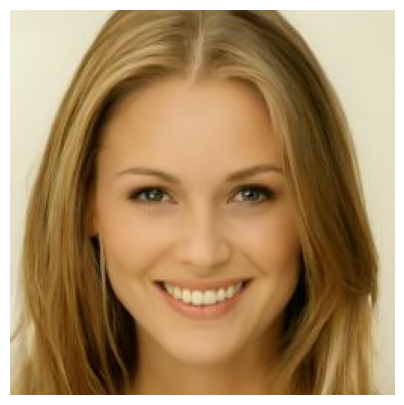

In [15]:
TI = 100
scheduler.set_timesteps(TI)
res = ddpm_sampling(model, scheduler)
plt.figure(figsize=(5, 5))
plt.imshow(util.tensor2uint(res))
plt.axis('off')
plt.show()

## III) Diffusion models for inverse problems<a class="anchor" id="chapter3"></a>

### Introduction



Consider an inverse problem with Gaussian likelihood

$$p(y|x) = \mathcal{N}(Hx,\sigma^2I) $$

and prior $p(x)$ given by a diffusion model.

Recall from Question 4 that the DDPM update rule can be written in terms of the score function as

$$
\begin{align*}
&  x_{t-1}' = \frac{1}{\sqrt{\alpha_t}} \left(x_{t} + \beta_t \nabla \log p(x_t) \right) + \sigma_t z_t & (1)
\end{align*}
$$

For inverse problems we target the posterior $p(x|y)$ instead of the prior $p(x)$. This means that the score function in the previous equation should be substituted by

$$\nabla_{x_t} \log{p(x_t|y)} = \nabla_{x_t} \log{p_t(x_t)} + \nabla_{x_t} \log{p_t(y|x_t)}$$

This leads to the following DDPM update rule for posterior sampling
$$
\begin{align*}
x_{t-1} & = \frac{1}{\sqrt{\alpha_t}} \left(
		x_{t} + \beta_t (\nabla \log p(x_t) + \nabla \log p(y|x_t))
\right) + \sigma_t z_t 
 & (2)\\
& = \underbrace{
\frac{1}{\sqrt{\alpha_t}} \left(x_{t} + \beta_t \nabla \log p(x_t) \right) + \sigma_t z_t
}_{=x_{t-1}'}
+ \frac{\beta_t}{\sqrt{\alpha_t}} \nabla \log p(y|x_t) &
\end{align*}
$$
All the terms in the previous equation are known except for $p_t(y|x_t)$.

But we do know $p_t(y|x_0)$.

In addition the link between $x_0$ and $x_t$ is provided by the forward and backward process.

<div>
<img src="images_notebook/DPS_distrib.png" width="300"/>
</div>

Therefore we could compute the unknown term by marginalization:
$$
\begin{align*}

& p(y|x_t) = \int p(x_0|x_t)p(y|x_0)dx_0 & (3)

\end{align*}
$$

The computation of this integral is intractable in general. But it can be computed in closed form if we adopt an approximation of $p(x_0|x_t)$.

In the next section, we present two different approximations that provide two conditional sampling algorithms from an unconditional diffusion model: DPS and $\Pi$GDM.

### Get a sample from the dataset

The dataset below contains:
* 20 images $x$ of size 256x256 (from FFHQ face image database)
* several blur kernels $k$ of size 33x33 (simulated camera shake kernels)

From a given pair $(x, k)$, it generates a blurred and noisy image
$$ y = \underbrace{k * x}_{=H x} + \mathcal{N}(0,\sigma^2 Id) $$

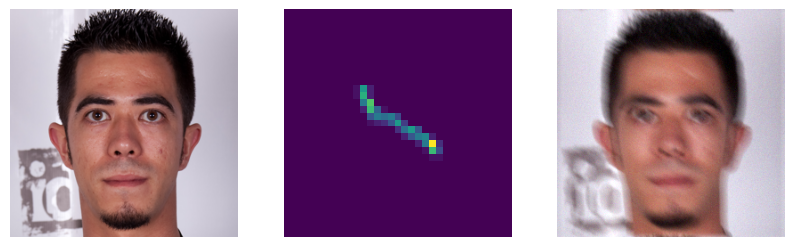

In [24]:
from data.data_blur import Dataset
from numpy import random

data_opt = {'dataroot_H': HOMEDIR + '/data/FFHQ/GT/H',
            'dataroot_kernels': HOMEDIR + '/data/kernels/custom_blur_centered.mat',
            'sigma': [1,2]}

data = Dataset(data_opt)

# Get a sample from the dataset
k = random.randint(0, 19)
sample = data[k]
x = sample['H'] # original (ground truth) image - image k
k = sample['kernel'] # blur kernel - selected randomly (independently from k)
y = sample['L'] # degraded (blurred + noisy) image y = k*x + n


plt.figure(figsize=(10, 10/3))
plt.subplot(131)
plt.imshow(util.tensor2uint(x))
plt.axis('off')
plt.subplot(132)
plt.imshow(util.tensor2uint(k))
plt.axis('off')
plt.subplot(133)
plt.imshow(util.tensor2uint(y))
plt.axis('off')
plt.show()

### Diffusion by Posterior Sampling (DPS)<a class="anchor" id="section_3_1"></a>

DPS approximates $p(x_0|x_t)$ by a Dirac centered at the posterior mean $\widehat{x_0}(x_t) = E[x_0|x_t]$.

In other words, $p(x_0|x_t) \approx \delta_{\widehat{x_0}(x_t)}(x_0)$.

Substituting this approximation in equation (3) we obtain:

$$-\nabla_{x_t}\log{p(y|x_t)} = \nabla_{x_t} {\frac{1}{2\sigma^2}\|H\widehat{x_0}(x_t) - y\|_2^2} =: g$$

This guidance term $g$ can be computed using automatic differentiation

> **Question 5:** Assume that the torch tensor `f` holds the expression $$ -\log{p(y|x_t)}+C = \frac{1}{2\sigma^2} \|H\widehat{x_0}(x_t) - y\|_2^2 =: f.$$ 
> Use  `torch.autograd.grad` to compute $\nabla_{x_t} f$. Complete the DPS code below.

Combining this with equation (2) above we obtain the **DPS update rule**
$$x_{t-1} = x_{t-1}' - \eta_t g$$

where 

* $x_{t-1}'$ is the update rule for the unconditional DDPM sampler,
* $g$ is the guidance term to make it conditional (on the observation $y$), and 
* $\eta_t$ is a guidance weight.

> **Question 6:** According to equation (2) what should be the value of $\eta_t$ ? Complete the DPS code below.

The authors of DPS prefer to set $\eta_t = 1$ for all $t$ instead of the theoretical value below. You shall compare both approaches below.

> **Question 7:** Assume that the likelihod is not Gaussian, but governed by some Gibbs density $\log p(y|x_0) +C = \mathcal{A}(x_0)$. Can you still apply DPS if $\mathcal{A}$ is differentiable?

> **Question 8:** Compare the results of DPS with fixed and adaptive $\eta_t$ with $\Pi$ GDM below.

Reference:
- DPS: https://openreview.net/forum?id=OnD9zGAGT0k

In [33]:
import utils.utils_agem as agem

def alpha_beta(scheduler, t):
    prev_t = scheduler.previous_timestep(t)
    alpha_prod_t = scheduler.alphas_cumprod[t]
    alpha_prod_t_prev = scheduler.alphas_cumprod[prev_t] if prev_t >= 0 else scheduler.one
    current_alpha_t = alpha_prod_t / alpha_prod_t_prev
    current_beta_t = 1 - current_alpha_t
    return current_alpha_t, current_beta_t


# DPS with DDPM and intrinsic scale
def dps_sampling(model, scheduler, y, foward_model, nsamples=1, scale=1, scale_guidance=1):
    sample_size = model.config.sample_size
    
    # Init random noise
    x_T = torch.randn((nsamples, 3, sample_size, sample_size)).to(device)
    x_t = x_T

    for t in tqdm.tqdm(scheduler.timesteps):
        
        # Predict noisy residual eps_theta(x_t)
        x_t.requires_grad_()
        epsilon_t = model(x_t, t).sample

        # Get x0_hat and unconditional 
        # x_{t-1} = a_t * x_t + b_t * epsilon(x_t) + sigma_t z_t
        # with b_t = eta_t
        predict = scheduler.step(epsilon_t, t, x_t) 
        x0_hat  = agem.clean_output(predict.pred_original_sample)
        x_prev  = predict.prev_sample # unconditional DDPM sample x_{t-1}'
        
        # Guidance
        f = torch.norm(forward_model(x0_hat) - y)
        # g = # ... COMPLETE THIS LINE!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        g = torch.autograd.grad(f, x0_hat)[0]
        
        # compute variance schedule
        alpha_t, beta_t= alpha_beta(scheduler, t)

        # Guidance weight
        # eta_t = ...
        if (scale_guidance==1):
            pass
            # eta_t =  # ... COMPLETE THIS LINE
            #######"!!!!"!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
            eta_t = 1.
        else:
            eta_t = 1.0

        # DPS update rule = DDPM update rule + guidance
        x_t = x_prev - scale * eta_t * g
        x_t = x_t.detach_()

    return agem.clean_output(x_t)

# BALTH: Compute!!!  $\eta_t$ theorique  mais en pratique auteurs = 1




#### Fixed $\eta_t =1$

Now we are ready to run the DPS algorithm with fixed $\eta_t = 1$.

For best results you should use T=1000 steps. (about 5 minutes)

For faster results you can use T=100 steps. (about 30 seconds)

In [34]:
# torch.roll is not supported for MPS device, so we need to enable CPU fallback
%env PYTORCH_ENABLE_MPS_FALLBACK=1

#scheduler = DDPMScheduler.from_pretrained(model_name)
#model = UNet2DModel.from_pretrained(model_name).to(device)

ddpm = DDPMPipeline.from_pretrained(model_name).to(device)
scheduler = ddpm.scheduler
model = ddpm.unet

T = 100
scheduler.set_timesteps(T)
# print_scheduler(scheduler, T, 10)


# Forward model (cuda GPU implementation)
# forward_model = lambda x: agem.fft_blur(x, sample['kernel'].to(device))
# If you are using an MPS gpu use the following forward_model instead
# CPU fallback implementation (no MPS support for torch.roll, fft2, Complex Float, etc.)
forward_model_cpu = lambda x: agem.fft_blur(x, sample['kernel'])


#### PAS BESOIN DE CPU normalement
forward_model = lambda x: forward_model_cpu(x.to('cpu')).to(device)



# Degraded image y = A x + noise
y = sample['L'].to(device)
# DPS sampling
res = dps_sampling(model, scheduler, y, forward_model, 1, scale=1, scale_guidance=0)
# Ground truth image x
x = sample['H'].to(device)

plt.figure(figsize=(10, 10/3))
plt.subplot(131)
plt.imshow(util.tensor2uint(y))
plt.axis('off')
plt.subplot(132)
plt.imshow(util.tensor2uint(res))
plt.axis('off')
plt.subplot(133)
plt.imshow(util.tensor2uint(x))
plt.axis('off')
plt.show()

import utils.utils_image as image_utils
image_utils.calculate_psnr(util.tensor2uint(res), util.tensor2uint(sample['H']))

env: PYTORCH_ENABLE_MPS_FALLBACK=1


diffusion_pytorch_model.safetensors not found


Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 0 has a total capacty of 3.81 GiB of which 704.00 KiB is free. Including non-PyTorch memory, this process has 3.81 GiB memory in use. Of the allocated memory 3.68 GiB is allocated by PyTorch, and 54.83 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

#### Adaptive $\eta_t$

Now we are ready to run the DPS algorithm with the theoretical (adaptive) values of $\eta_t$.

First have a look at the scheduler to see how $\eta_t$ varies with $t$.
`print_scheduler(scheduler, T, 10)`
Then set the value of the scale paraameter accordingly.

For best results you should use T=1000 steps. (about 5 minutes)

For faster results you can use T=100 steps. (about 30 seconds)

In [29]:
# torch.roll is not supported for MPS device, so we need to enable CPU fallback
%env PYTORCH_ENABLE_MPS_FALLBACK=1

#scheduler = DDPMScheduler.from_pretrained(model_name)
#model = UNet2DModel.from_pretrained(model_name).to(device)

ddpm = DDPMPipeline.from_pretrained(model_name).to(device)
scheduler = ddpm.scheduler
model = ddpm.unet

T = 100
scheduler.set_timesteps(T)
print_scheduler(scheduler, T, 10)


# Forward model (cuda GPU implementation)
# forward_model = lambda x: agem.fft_blur(x, sample['kernel'].to(device))
# If you are using an MPS gpu use the following forward_model instead
# CPU fallback implementation (no MPS support for torch.roll, fft2, Complex Float, etc.)
forward_model_cpu = lambda x: agem.fft_blur(x, sample['kernel'])
forward_model = lambda x: forward_model_cpu(x.to('cpu')).to(device)
# Degraded image y = A x + noise
y = sample['L'].to(device)
# DPS sampling
res = dps_sampling(model, scheduler, y, forward_model, 1, scale=100, scale_guidance=1)
# Ground truth image x
x = sample['H'].to(device)

plt.figure(figsize=(10, 10/3))
plt.subplot(131)
plt.imshow(util.tensor2uint(y))
plt.axis('off')
plt.subplot(132)
plt.imshow(util.tensor2uint(res))
plt.axis('off')
plt.subplot(133)
plt.imshow(util.tensor2uint(x))
plt.axis('off')
plt.show()

import utils.utils_image as image_utils
image_utils.calculate_psnr(util.tensor2uint(res), util.tensor2uint(sample['H']))

env: PYTORCH_ENABLE_MPS_FALLBACK=1


diffusion_pytorch_model.safetensors not found


Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

T t eta_t alpha_prod_t beta_prod_t current_beta_t
100 0 tensor(0.0001) tensor(0.9999) tensor(0.0001) tensor(0.0001)
100 10 tensor(0.0021) tensor(0.9978) tensor(0.0022) tensor(0.0021)
100 20 tensor(0.0041) tensor(0.9937) tensor(0.0063) tensor(0.0041)
100 30 tensor(0.0061) tensor(0.9877) tensor(0.0123) tensor(0.0061)
100 40 tensor(0.0081) tensor(0.9798) tensor(0.0202) tensor(0.0080)
100 50 tensor(0.0101) tensor(0.9700) tensor(0.0300) tensor(0.0100)
100 60 tensor(0.0121) tensor(0.9583) tensor(0.0417) tensor(0.0120)
100 70 tensor(0.0141) tensor(0.9449) tensor(0.0551) tensor(0.0140)
100 80 tensor(0.0161) tensor(0.9299) tensor(0.0701) tensor(0.0159)
100 90 tensor(0.0180) tensor(0.9133) tensor(0.0867) tensor(0.0179)


  0%|          | 0/100 [00:00<?, ?it/s]


UnboundLocalError: local variable 'eta_t' referenced before assignment

### 2)  Pseudoinverse-Guided Diffusion Models ($\Pi$GDM))<a class="anchor" id="section_3_2"></a>

In $\Pi$GDM, $p(x_0|x_t)$ is approximated with a Gaussian distribution. We have $p(x_0|x_t)\sim \mathcal{N}(\widehat{x_0}, r_t^2)$.

Now since both $p(x_0|x_t)$ and $p(y|x_0)$ are Gaussian, we can compute the posterior $p(y|x_t)$ in closed form:

$$p(y|x_t) \sim \mathcal{N}(H\widehat{x_0}, r_t^2 HH^T + \sigma^2Id)$$

which leads to:
$$\nabla_{x_t} \log{p(y|x_t)} = \left(\frac{\partial \widehat{x_0}(x_t)}{\partial x_t}\right)^T H^T (r_t^2 HH^T + \sigma^2Id)^{-1} (y - H \widehat{x_0})$$

Autograd is able to do most of the job, but we still need to invert $(r_t^2 HH^T + \sigma^2Id)$. This computation can be expensive, unless $H$ has some special structure. For deblurring, $H$ is a convolution operator, so we can use the FFT to compute the inverse efficiently.

***

$\Pi$GDM "guidance" is more efficient that DPS, which means we do not need as much iterations as DPS (between 50 and 100). However, the cost of a strong guidance comes with limitations on the complexity of the forward operator $H$.

Reference:
- $\Pi$GDM: https://openreview.net/forum?id=9_gsMA8MRKQ

In [ ]:
%env PYTORCH_ENABLE_MPS_FALLBACK=1
import torch.fft as fft

def pinv_deblurring(x, k, r=1, sigma=1e-8):
    k = agem.p2o(k, x.shape[-2:])
    Fk = fft.fft2(k)
    FkC = Fk.conj()
    Fk2 = Fk.mul(FkC)
    num = FkC
    den = r ** 2 * Fk2 + sigma ** 2
    res = (num / den) * fft.fft2(x)
    return fft.ifft2(res).real

def deblurring_guidance(y, x, k, sigma=0, r=1):
    if sigma == 0:
        sigma += 1e-8
    if (device == torch.device("mps")):
        # Enable CPU fallback for FFT operations
        y = y.to("cpu")
        x = x.to("cpu")
        k = k.to("cpu")
        result = pinv_deblurring(y, k, r=r, sigma=sigma) - pinv_deblurring(agem.fft_blur(x, k), k, r=r, sigma=sigma)
        result = result.to(device)
    else:
        result = pinv_deblurring(y, k, r=r, sigma=sigma) - pinv_deblurring(agem.fft_blur(x, k), k, r=r, sigma=sigma)
    return result

In [ ]:
def pigdm_sampling(model, scheduler, y, sigma, guidance, n, scale=1):    
    sample_size = model.config.sample_size
    step_size = scheduler.config.num_train_timesteps // scheduler.num_inference_steps
    
    # Init random noise
    input = torch.randn((n, 3, sample_size, sample_size)).to(device)

    for t in tqdm.tqdm(scheduler.timesteps):
        # Computation of some hyper-params
        prev_t = t - step_size
        variance = scheduler._get_variance(t, prev_t)
        r = torch.sqrt(variance/(variance + 1))
        current_alpha_t = 1 / (1 + variance)

        # Predict noise
        input.requires_grad_()
        noisy_residual = model(input, t).sample

        # Get x_prec and x0_hat
        pred = scheduler.step(noisy_residual, t, input)
        x0_hat = agem.clean_output(pred.pred_original_sample)
        x_prec = pred.prev_sample

        # Guidance
        g = (guidance(y, x0_hat, sigma=sigma, r=r).detach() * x0_hat).sum()
        grad = torch.autograd.grad(outputs=g, inputs=input)[0]
        input = input.detach_()

        # Update of x_t
        input = x_prec + scale * grad * (r ** 2) * torch.sqrt(current_alpha_t)

    return agem.clean_output(input)

In [ ]:
#scheduler = DDIMScheduler.from_pretrained("google/ddpm-celebahq-256")
#model = UNet2DModel.from_pretrained("google/ddpm-celebahq-256").to("cuda")

ddpm = DDPMPipeline.from_pretrained(model_name).to(device)
scheduler = ddpm.scheduler
model = ddpm.unet
scheduler.set_timesteps(100)

guidance = lambda y, x, sigma, r: deblurring_guidance(y, x, sample['kernel'].to(device), sigma=sigma, r=r)
res = pigdm_sampling(model, scheduler, sample['L'].to(device), sample['sigma'], guidance, 1)

plt.figure(figsize=(10, 10/3))
plt.subplot(131)
plt.imshow(util.tensor2uint(sample['L']))
plt.axis('off')
plt.subplot(132)
plt.imshow(util.tensor2uint(res))
plt.axis('off')
plt.subplot(133)
plt.imshow(util.tensor2uint(sample['H']))
plt.axis('off')
plt.show()

import utils.utils_image as image_utils
image_utils.calculate_psnr(util.tensor2uint(res), util.tensor2uint(sample['H']))